In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as de
import os
import sys

import fbprophet

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

In [19]:
win_path = 'C:/Users/noname/Desktop/wuzhatn'
mac_path = '/Users/noname/documents/github/wuzhatn'
wrk_path = 'C:/Users/user/Documents/GitHub/wuzhatn'

if os.path.exists(win_path):
    main = win_path
elif os.path.exists(mac_path):
    main = mac_path
else:
    main = wrk_path

raw = main + '/raw'
bank_folder = main[:main.rfind('/')] + '/bank'
sys.path.append(bank_folder)
import mih

years = range(2011,2019,1)
y2u = range(2014,2019,1)

In [20]:
print(wrk_path)
wrk_path.rfind('/')
print(wrk_path[:30])

C:/Users/user/Documents/GitHub/wuzhatn
C:/Users/user/Documents/GitHub


In [23]:
all_ds = {}
hum_ds = {}
for y in y2u:
    all_ds[y] = pd.read_excel(f'{raw}/일별평균대기오염도_{str(y)}.xlsx', usecols=[0,1,6,7])
    all_ds[y].columns = ['dt','loca','pm10','pm25']
    all_ds[y]['loca'] = all_ds[y]['loca'].str[:-1]
    all_ds[y].dropna(axis=1, how='all', inplace=True)
    
    hum_ds[y] = pd.read_excel(f'{raw}/일별기상관측_{str(y)}.xlsx', usecols=[0,1,5])
    hum_ds[y].columns = ['dt','loca','ave_hum']
    all_ds[y].dropna(axis=1, how='all', inplace=True)

# let's just work with gangnam

In [24]:
ds = pd.DataFrame()
for y in y2u:
    t = all_ds[y][all_ds[y]['loca']=='강남'].merge(
        hum_ds[y][hum_ds[y]['loca']=='강남'], on=['dt','loca'], how='outer')
    ds = ds.append(t)
    
ds['dt'] = pd.to_datetime(ds['dt'], format='%Y%m%d')
ds.set_index('dt', inplace=True)
fm2 = pd.date_range('2014-1-1', '2018-12-31')
ds = ds.reindex(fm2, fill_value=np.nan)

ds.loc[ds['loca'].isna()==True,'loca'] = '강남'
for v in ds.columns[ds.isnull().any()]:
    ds[v] = ds[v].interpolate(method='linear')

ds.head()

,loca,pm10,pm25,ave_hum
2014-01-01,강남,117.0,29.0,58.9
2014-01-02,강남,54.0,23.0,40.4
2014-01-03,강남,59.0,30.0,58.4
2014-01-04,강남,49.0,25.0,54.8
2014-01-05,강남,42.0,25.0,52.1


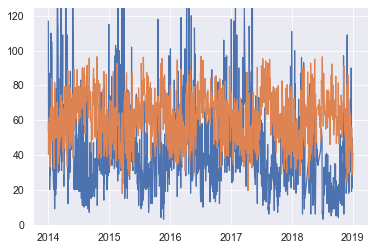

In [25]:
plt.ylim([0,125])
plt.plot(ds['pm10'])
plt.plot(ds['ave_hum'])

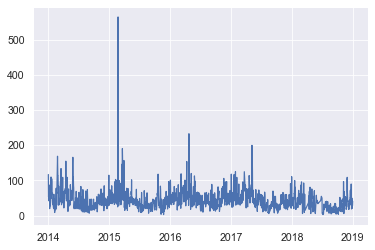

In [26]:
plt.plot(ds['pm10'])

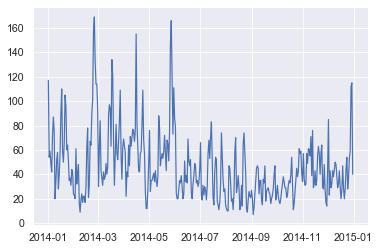

In [27]:
plt.plot(ds.loc['2014-1-1':'2014-12-31','pm10'])

# straignt up copy from here

loca       0 
pm10       12
pm25       0 
ave_hum    0 
dtype: int64


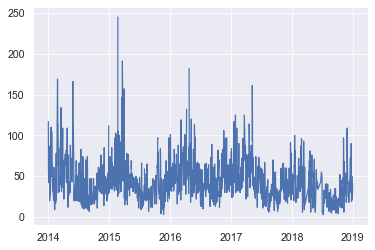

In [28]:
dc = ds.copy()
dc.loc[:,'pm10'] = mih.median_filter(dc, varname='pm10')
print(dc.isna().sum())
plt.plot(dc['pm10'])

In [29]:
fm = '2014-1-1'
tu = '2014-12-31'
# subs = dc.loc[fm:tu]
subs = dc

seas_cycl = subs.loc[:,'pm10'].rolling(window=30, center=True).\
            median().groupby(subs.index.dayofyear).median()
q25 = subs.loc[:,'pm10'].rolling(window=30, center=True).\
            median().groupby(subs.index.dayofyear).quantile(0.25)
q75 = subs.loc[:,'pm10'].rolling(window=30, center=True).\
            median().groupby(subs.index.dayofyear).quantile(0.75)

In [30]:
from calendar import day_abbr, month_abbr, mdays
ndays_m = mdays.copy()
ndays_m[2] = 29
ndays_m = np.cumsum(ndays_m)
month_abbr = month_abbr[1:]
print(month_abbr)

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


Text(0.5, 1.0, 'Running Average of Daily PM10 Level from 2014 to 2018')

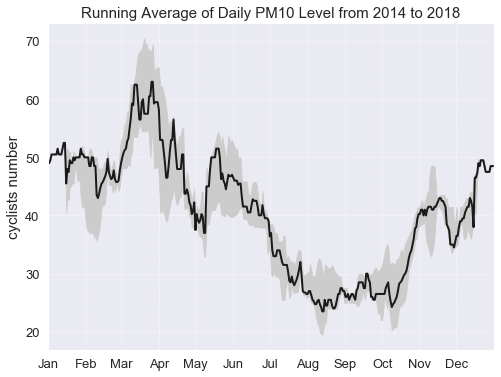

In [31]:
f, ax = plt.subplots(figsize=(8,6)) 

seas_cycl.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(seas_cycl.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

ax.set_xticks(ndays_m)
ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

ax.set_xlabel('', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Running Average of Daily PM10 Level from 2014 to 2018', fontsize=15)

In [32]:
dc.head()

,loca,pm10,pm25,ave_hum
2014-01-01,강남,117.0,29.0,58.9
2014-01-02,강남,54.0,23.0,40.4
2014-01-03,강남,59.0,30.0,58.4
2014-01-04,강남,49.0,25.0,54.8
2014-01-05,강남,42.0,25.0,52.1


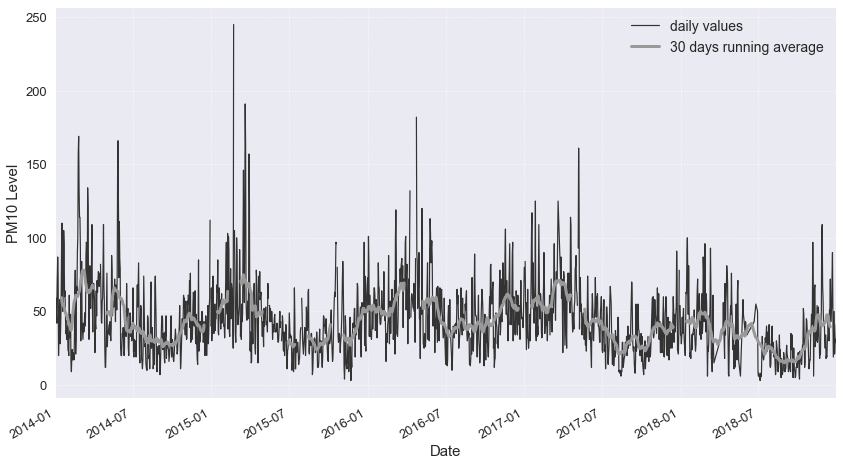

In [42]:
data = dc[['pm10']]
f, ax = plt.subplots(figsize=(14,8))

# plt.plot(data)
# data.plot(ax=ax, color='0.2')
plt.plot(data, color='0.2')
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3, color='0.6')

ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('PM10 Level', fontsize=15);
# ax.axvline('2018-01-01', color='0.8', lw=8, zorder=-1)
data.rename(columns={'pm10':'y', 'index':'ds'}, inplace=True)

In [48]:
data_train, data_test = mih.prepare_data(data, 2018)
data_train.rename(columns={'index':'ds'}, inplace=True)
data_test.rename(columns={'index':'ds'}, inplace=True)
display(data_train.tail())
display(data_test.head())

,ds,y
1456,2017-12-27,21.0
1457,2017-12-28,37.0
1458,2017-12-29,78.0
1459,2017-12-30,NaN
1460,2017-12-31,54.0


,ds,y
0,2018-01-01,34.0
1,2018-01-02,34.0
2,2018-01-03,28.0
3,2018-01-04,34.0
4,2018-01-05,46.0


In [49]:
Prophet = fbprophet.Prophet
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [50]:
m.fit(data_train)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [51]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')
future.head()

,ds
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
